# Build a Model Factory

A model factory is a system or set of procedures that automatically generate predictive models with little to no human intervention. Model factories can have multiple layers of complexity, called modules. One module may train models while others can deploy or retrain models. In this example of a model factory, you set up projects and start them in a _parallel_ loop. This allows you to start all projects simultaneously, without unexpected errors.

Consider a scenario where you have 20,000 SKUs and you need to do sales forecasting for each one of them. Or, you may have multiple types of customers and you are trying to predict which types will churn.

* Can one model handle the high dimensionality that comes with these problems?
* Is a single model family able to address the scope of these problems?
* Is one preprocessing method sufficient?

In this example, use DataRobot to build a single project with the readmitted dataset to predict the probability that a hospital patient may be readmitted after discharge. Then, you will build multiple projects with the `admission id` feature as the target and find the best model for unique value for `admission id`. Lastly, you will prepare the selected models for deployment.

### Import Libraries

In [2]:
from time import sleep

from dask import compute, delayed  # For parallelization
import datarobot as dr  # Requires version >2.19
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(style="whitegrid")

### Import data

Download the sample dataset [here](10k-diabetes.csv).

In [3]:
data_path = "https://docs.datarobot.com/en/docs/api/guide/python/10k-diabetes.csv"

df = pd.read_csv(data_path)

In [41]:
# Display the data
df.head()

race  gender      age   weight admission_type_id  \
0        Caucasian  Female  [50-60)        ?          Elective   
1        Caucasian  Female  [20-30)  [50-75)            Urgent   
2        Caucasian    Male  [80-90)        ?     Not Available   
3  AfricanAmerican  Female  [50-60)        ?         Emergency   
4  AfricanAmerican  Female  [50-60)        ?         Emergency   

                            discharge_disposition_id  \
0                                 Discharged to home   
1                                 Discharged to home   
2  Discharged/transferred to home with home healt...   
3                                 Discharged to home   
4                                 Discharged to home   

                          admission_source_id  time_in_hospital payer_code  \
0                          Physician Referral                 1         CP   
1                          Physician Referral                 2         UN   
2                                         NaN                 7         MC   
3  Transfer from another health care facility                 4         UN   
4                              Emergency Room                 5          ?   

        medical_specialty  ...  glipizide_metformin  glimepiride_pioglitazone  \
0           Surgery-Neuro  ...                   No                        No   
1                       ?  ...                   No                        No   
2  Family/GeneralPractice  ...                   No                        No   
3                       ?  ...                   No                        No   
4              Psychiatry  ...                   No                        No   

   metformin_rosiglitazone  metformin_pioglitazone  change  diabetesMed  \
0                       No                      No      No           No   
1                       No                      No      No           No   
2                       No                      No      No          Yes   
3                       No                      No      No          Yes   
4                       No                      No      Ch          Yes   

  readmitted                                        diag_1_desc  \
0      False                 Spinal stenosis in cervical region   
1      False  First-degree perineal laceration, unspecified ...   
2       True  Pneumococcal pneumonia [Streptococcus pneumoni...   
3      False                     Cellulitis and abscess of face   
4      False  Bipolar I disorder, single manic episode, unsp...   

                                         diag_2_desc  \
0                 Spinal stenosis in cervical region   
1  Diabetes mellitus of mother, complicating preg...   
2              Congestive heart failure, unspecified   
3  Streptococcus infection in conditions classifi...   
4  Diabetes mellitus without mention of complicat...   

                                         diag_3_desc  
0                Effusion of joint, site unspecified  
1                               Sideroblastic anemia  
2               Hyperosmolality and/or hypernatremia  
3  Diabetes mellitus without mention of complicat...  
4                          Depressive type psychosis  

[5 rows x 51 columns]

### Connect to DataRobot

DataRobot recommends providing a configuration file containing your credentials (endpoint and API Key) to connect to DataRobot.

In [ ]:
# If the config file is not in the default location described in the API Quickstart guide, '~/.config/datarobot/drconfig.yaml', then you will need to call
# dr.Client(config_path='path-to-drconfig.yaml')

### Create a project
Create a Datarobot project and initiate Autopilot using data from all patients in the dataset.

In [ ]:
original_proj = dr.Project.start(
    df,  # Pandas dataframe with data
    project_name="Readmissions",  # Name of the project
    target="readmitted",  # Target of the project
    metric="LogLoss",  # Optimization metric (Default is LogLoss)
    worker_count=-1,
)  # Amount of workers to use (-1 means every worker available)

original_proj.wait_for_autopilot(
    verbosity=1
)  # Wait for Autopilot to finish. You can set verbosity to 0 if you do not wish to see progress updates

### Get the best-performing model from the project

In [ ]:
# Choose the most accurate model
best_model = original_proj.get_models()[0]

print(best_model)  # Print the most accurate model's name
best_model.metrics["LogLoss"]["crossValidation"]  # Print the crossValidation score

### Model insight functions
Use the functions below to plot the ROC curve and Feature Impact for a model.

In [8]:
def plot_roc_curve(datarobot_model):
    """This function plots a roc curve.
    Input:
        datarobot_model: <Datarobot Model object>
    """
    roc = datarobot_model.get_roc_curve("crossValidation")
    roc_df = pd.DataFrame(roc.roc_points)
    auc_score = datarobot_model.metrics["AUC"]["crossValidation"]
    plt.plot(
        roc_df["false_positive_rate"],
        roc_df["true_positive_rate"],
        "b",
        label="AUC = %0.2f" % auc_score,
    )
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()


def plot_feature_impact(datarobot_model, title=None):
    """This function plots feature impact
    Input:
        datarobot_model: <Datarobot Model object>
        title : <string> --> title of graph
    """
    # Get feature impact
    feature_impacts = datarobot_model.get_or_request_feature_impact()

    # Sort feature impact based on normalised impact
    feature_impacts.sort(key=lambda x: x["impactNormalized"], reverse=True)

    fi_df = pd.DataFrame(feature_impacts)  # Save feature impact in pandas dataframe
    fig, ax = plt.subplots(figsize=(14, 5))
    b = sns.barplot(x="featureName", y="impactNormalized", data=fi_df[0:5], color="b")
    b.axes.set_title("Feature Impact" if not title else title, fontsize=20)


def wait_for_autopilot(proj, wait=120):
    total_wait = 0
    while proj.get_status()["autopilot_done"] == False:
        sleep(wait)
        total_wait += wait
        total_jobs = len(proj.get_all_jobs())
        print(
            "Autopilot still running! {} jobs running and in queue. Total wait time {}s".format(
                total_jobs, total_wait
            )
        )

### Visualize the ROC Curve

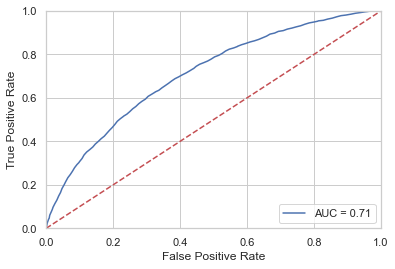

In [9]:
plot_roc_curve(best_model)

### Plot Feature Impact

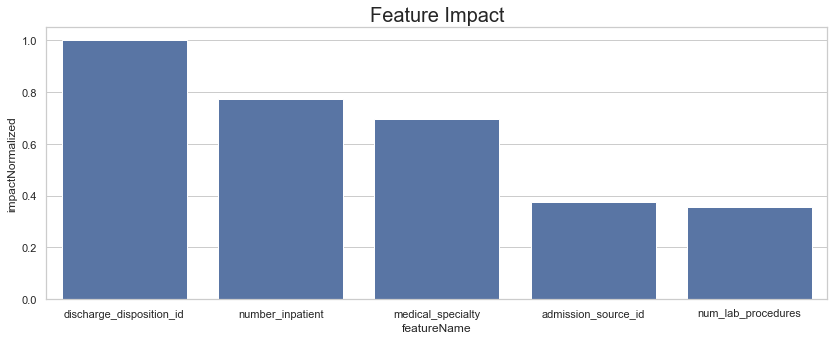

In [10]:
plot_feature_impact(best_model)

### Build a better model

Use the `admission_type` feature as a splitting point to create multiple projects.

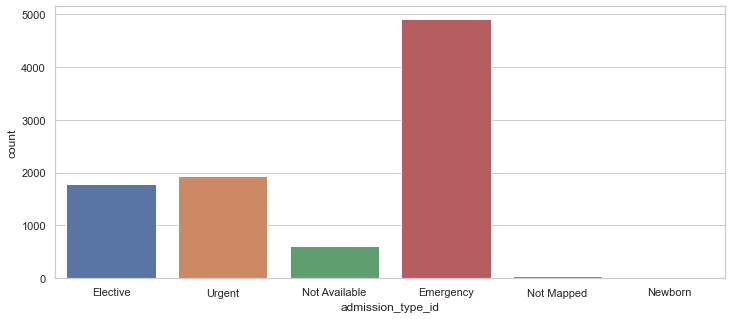

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
c = sns.countplot(x="admission_type_id", data=df)

## Create a mini model factory
Often when DataRobot needs to set up Automated Feature Discovery (AFD), it may take a while to perform Exploratory Data Analysis (EDA). You can save time when running multiple projects by initiating all of them in parallel. Use Python's dask module to do so.

In [12]:
def run_dr_factory(segment_num):
    try:
        temp_project = dr.Project.start(
            df.loc[df["admission_type_id"] == segment_num],
            project_name="Readmission_%s" % segment_num,
            target="readmitted",
            metric="LogLoss",
            worker_count=10,
        )
        return temp_project
    except:  # Catching the case when dataset has fewer than 20 rows.
        return f"There was an error in segment {segment_num}."

In [ ]:
delayed_dr_projects = []

# Create one project for each customer type
for value in df["admission_type_id"].unique():
    temp = delayed(run_dr_factory)(value)
    delayed_dr_projects.append(temp)

projects = compute(delayed_dr_projects)[0]
# Filter to the projects that did not throw errors
projects_filtered = [project for project in projects if not isinstance(project, str)]

### Get the best-performing model for each admission type

Even though accuracy changes may be insignificant for this dataset, in applicable cases a model factory can produce measurable value. This concept becomes increasingly important with a higher cardinality in your data. For example, consider if your business owns a variety of products, and you build a model factory to produce a model for each product. DataRobot saves you large amounts of time by having handling the evaluation of accuracy for separate set of models built for each product.

In [ ]:
best_models = {}  # To save models
for key, project in enumerate(projects_filtered):
    best_models[key] = projects_filtered[key].get_models()[0]
    print("--------------------------------")
    print("Best model for admission type id: %s" % project)
    print(best_models[key])
    print(best_models[key].metrics["LogLoss"]["crossValidation"])
    print("--------------------------------")

### Generate Feature Impact
Observe the differences in Feature Impact outlined below, which could lead to actionable insights.

In [ ]:
for key, project in enumerate(projects_filtered):
    plot_feature_impact(
        best_models[key], title="Feature Impact for admission type id: %s" % project
    )

### Deploy the most accurate models

After identifying the best-performing models, you can deploy them and use DataRobot's REST API to make HTTP requests with the deployment ID and return predictions. Once deployed, access monitoring capabilities such as:

- [Service health](https://docs.datarobot.com/en/docs/mlops/monitor/service-health.html)
- [Prediction accuracy](https://docs.datarobot.com/en/docs/mlops/monitor/deploy-accuracy.html)
- [Model retraining](https://docs.datarobot.com/en/docs/release/public-preview/mlops-preview/retraining.html)

In [ ]:
prediction_server = dr.PredictionServer.list()[0]

for key in best_models:
    temp_deployment = dr.Deployment.create_from_learning_model(
        best_models[key].id,
        label="Readmissions_admission_type: %s" % key,
        description="Test deployment",
        default_prediction_server_id=prediction_server.id,
    )